In [1]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os



                                                    seconds  \
5002.csv  [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...   
5003.csv  [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...   
5005.csv  [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...   
5006.csv  [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...   
5007.csv  [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...   

                                                        FHR  \
5002.csv  [125.79954772909109, 126.15128536748766, 126.4...   
5003.csv  [116.95482727197071, 117.07175038901416, 117.1...   
5005.csv  [151.67827425691627, 152.05073337698934, 152.4...   
5006.csv  [130.35000820411426, 130.5571024449305, 130.76...   
5007.csv  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                         UC    mean_fhr  \
5002.csv  [6.975518082173634, 6.9712125862851275, 6.9666...  135.881874   
5003.csv  [25.785611665129462, 25.77570021215365, 25.765...  127.752075   
5005.csv  [42.402

<Figure size 1500x500 with 0 Axes>

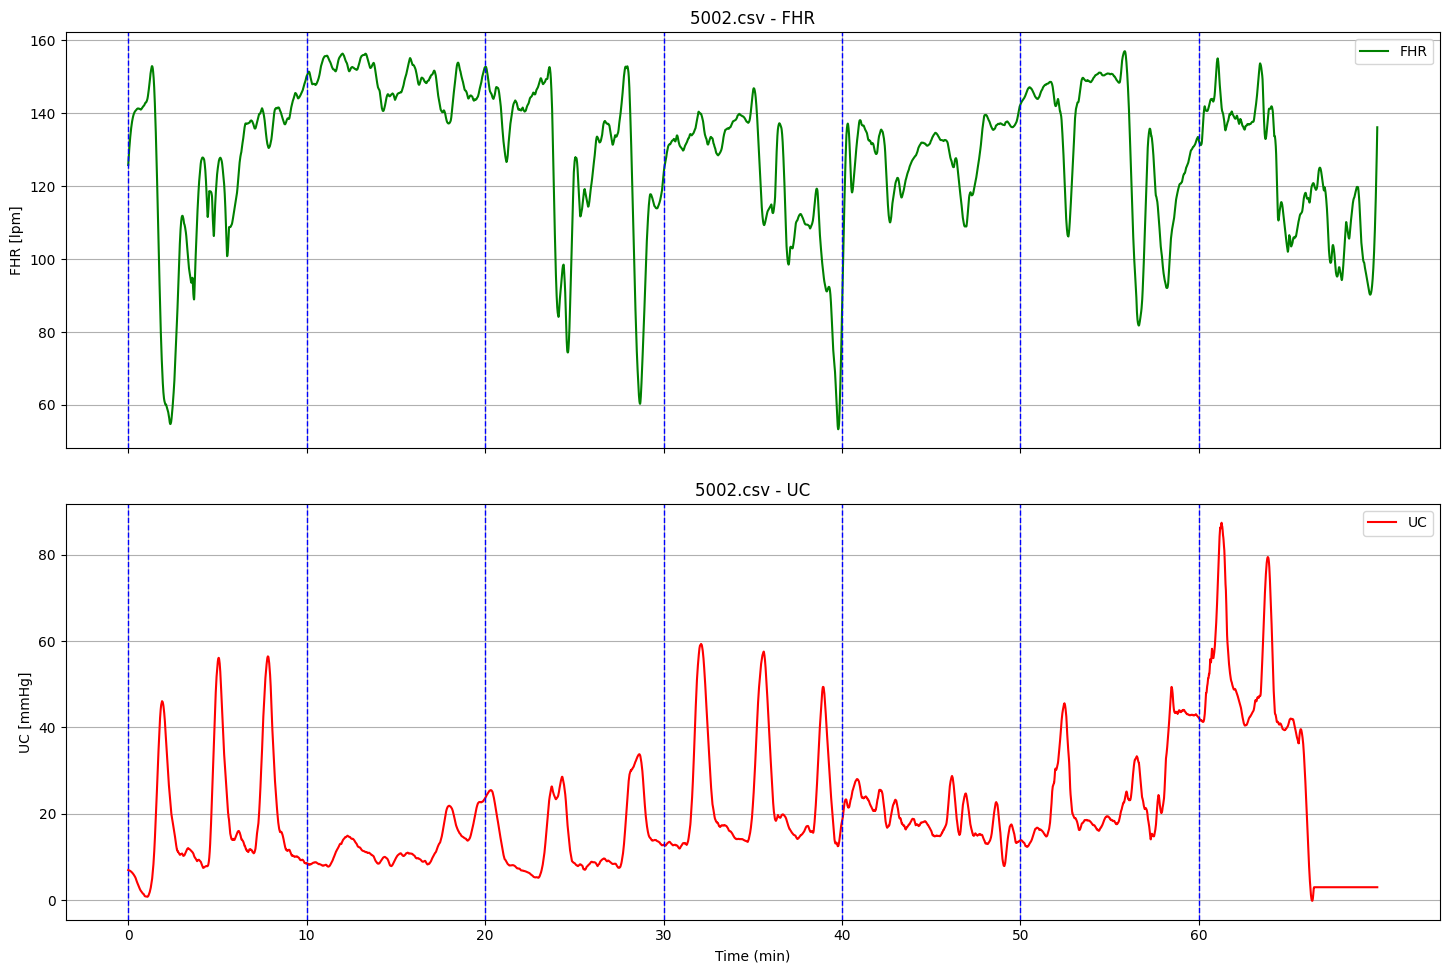

In [1]:
#codigo modificado por neuta 

from scipy.signal import savgol_filter, find_peaks
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

def calculate_fhr_metrics(fhr_values):
    # Media de la frecuencia cardíaca normal (110-160 lpm)
    normal_values = [val for val in fhr_values if 110 <= val <= 160]
    mean_fhr = np.mean(normal_values) if normal_values else np.nan

    # Contar el número de aceleraciones y desaceleraciones
    accelerations = [val for i, val in enumerate(fhr_values[1:], 1) if val - fhr_values[i-1] >= 15]
    decelerations = [val for i, val in enumerate(fhr_values[1:], 1) if fhr_values[i-1] - val >= 15]
    num_accelerations = len(accelerations)
    num_decelerations = len(decelerations)

    # Valor mínimo y máximo global
    min_fhr = np.min(fhr_values)
    max_fhr = np.max(fhr_values)

    # Contar el número de picos
    peaks, _ = find_peaks(fhr_values)
    num_peaks = len(peaks)

    # Desviación estándar
    std_dev_fhr = np.std(fhr_values)

    return mean_fhr, num_accelerations, num_decelerations, min_fhr, max_fhr, num_peaks, std_dev_fhr

def create_signals_dataset(path):
    fs = 4
    cols_data = []
    index = []

    files = sorted([f for f in os.listdir(path) if f.endswith(".csv")])

    for file in files:
        file_path = os.path.join(path, file)
        df = pd.read_csv(file_path, sep=",")

        # Preprocesamiento de datos
        df["FHR"] = df["FHR"].replace(0, np.nan).interpolate().fillna(0)
        df["UC"] = df["UC"].replace(0, np.nan).interpolate().fillna(0)

        # Filtrado de señales
        FHR_col = savgol_filter(df["FHR"].values, 200, 3)
        UC_col = savgol_filter(df["UC"].values, 200, 3)
        s_col = np.arange(len(df["seconds"].values)) / fs

        # Calcular las métricas de FHR
        mean_fhr, num_accelerations, num_decelerations, min_fhr, max_fhr, num_peaks, std_dev_fhr = calculate_fhr_metrics(FHR_col)

        # Almacenar los datos y las métricas en el dataframe
        data_row = [s_col, FHR_col, UC_col, mean_fhr, num_accelerations, num_decelerations, min_fhr, max_fhr, num_peaks, std_dev_fhr]
        cols_data.append(data_row)
        index.append(file)

    # Crear el dataframe final incluyendo las métricas calculadas
    columns = ['seconds', 'FHR', 'UC', 'mean_fhr', 'num_accelerations', 'num_decelerations', 'min_fhr', 'max_fhr', 'num_peaks', 'std_dev_fhr']
    DATASET = pd.DataFrame(cols_data, columns=columns, index=index)
    return DATASET

TRAIN_PATH = "./data/signals/train/"
TEST_PATH = "./data/signals/test/"

train_dataset = create_signals_dataset(TRAIN_PATH)
test_dataset = create_signals_dataset(TEST_PATH)

# Mostrar las primeras filas del dataset de entrenamiento
print(train_dataset.head())

# Graficar las señales para un archivo específico
file = "5002.csv"
seconds = train_dataset.loc[file]["seconds"]
FHR = train_dataset.loc[file]["FHR"]
UC = train_dataset.loc[file]["UC"]

# Convertir segundos a minutos
minutes = seconds / 60

# Crear la figura
plt.figure(figsize=(15, 5))

fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
fig.tight_layout(pad=3.0)

# Graficar FHR en el primer subplot
axs[0].plot(minutes, FHR, label="FHR", color="g")
for minute in range(0, int(max(minutes)), 10):
    axs[0].axvline(x=minute, color="b", linestyle="--", linewidth=1)
axs[0].set_title(f"{file} - FHR")
axs[0].set_ylabel("FHR [lpm]")
axs[0].set_xticks(range(0, int(max(minutes)), 10))
axs[0].legend()
axs[0].grid()

# Graficar UC en el segundo subplot
axs[1].plot(minutes, UC, label="UC", color="r")
for minute in range(0, int(max(minutes)), 10):
    axs[1].axvline(x=minute, color="b", linestyle="--", linewidth=1)
axs[1].set_title(f"{file} - UC")
axs[1].set_xlabel("Time (min)")
axs[1].set_ylabel("UC [mmHg]")
axs[1].set_xticks(range(0, int(max(minutes)), 10))
axs[1].legend()
axs[1].grid()

# Mostrar la figura
plt.show()


In [2]:
def create_signals_dataset(path):
    fs = 4
    cols_data = []
    index = []

    files = sorted([f for f in os.listdir(path) if f.endswith(".csv")])

    for file in files:
        file_path = os.path.join(path, file)
        df = pd.read_csv(file_path, sep=",")

        df["FHR"] = df["FHR"].replace(0, np.nan).interpolate().fillna(0)
        df["UC"] = df["UC"].replace(0, np.nan).interpolate().fillna(0)

        FHR_col = savgol_filter(df["FHR"].values, 200, 3)
        UC_col = savgol_filter(df["UC"].values, 200, 3)
        s_col = np.arange(len(df["seconds"].values)) / fs

        cols_data.append([s_col, FHR_col, UC_col])
        index.append(file)

    DATASET = pd.DataFrame(cols_data, columns=df.columns.values, index=index)
    return DATASET

In [3]:
TRAIN_PATH = "./data/signals/train/"
TEST_PATH = "./data/signals/test/"

train_dataset = create_signals_dataset(TRAIN_PATH)
test_dataset = create_signals_dataset(TEST_PATH)

In [4]:
train_dataset.head()

,seconds,FHR,UC
5002.csv,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[125.79954772909103, 126.1512853674876, 126.49...","[6.975518082173635, 6.971212586285128, 6.96665..."
5003.csv,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[116.95482727197071, 117.07175038901416, 117.1...","[25.785611665129455, 25.775700212153648, 25.76..."
5005.csv,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[151.67827425691624, 152.0507333769893, 152.41...","[42.402698796899784, 42.566633444941644, 42.72..."
5006.csv,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[130.35000820411426, 130.5571024449305, 130.76...","[15.897514917729557, 15.781976577751768, 15.66..."
5007.csv,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [5]:
test_dataset.head()

,seconds,FHR,UC
5001.csv,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[152.01467823056106, 151.84534402366543, 151.6...","[2.0223411790484143, 1.83961821510542, 1.66311..."
5004.csv,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[132.49743111006933, 132.54606620649471, 132.5...","[128.45508741713084, 128.24163370805, 128.0285..."
5010.csv,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5012.csv,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5020.csv,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[146.05796219251363, 146.13748425567616, 146.2...","[26.45142196154769, 26.339823506902007, 26.230..."


<Figure size 1500x500 with 0 Axes>

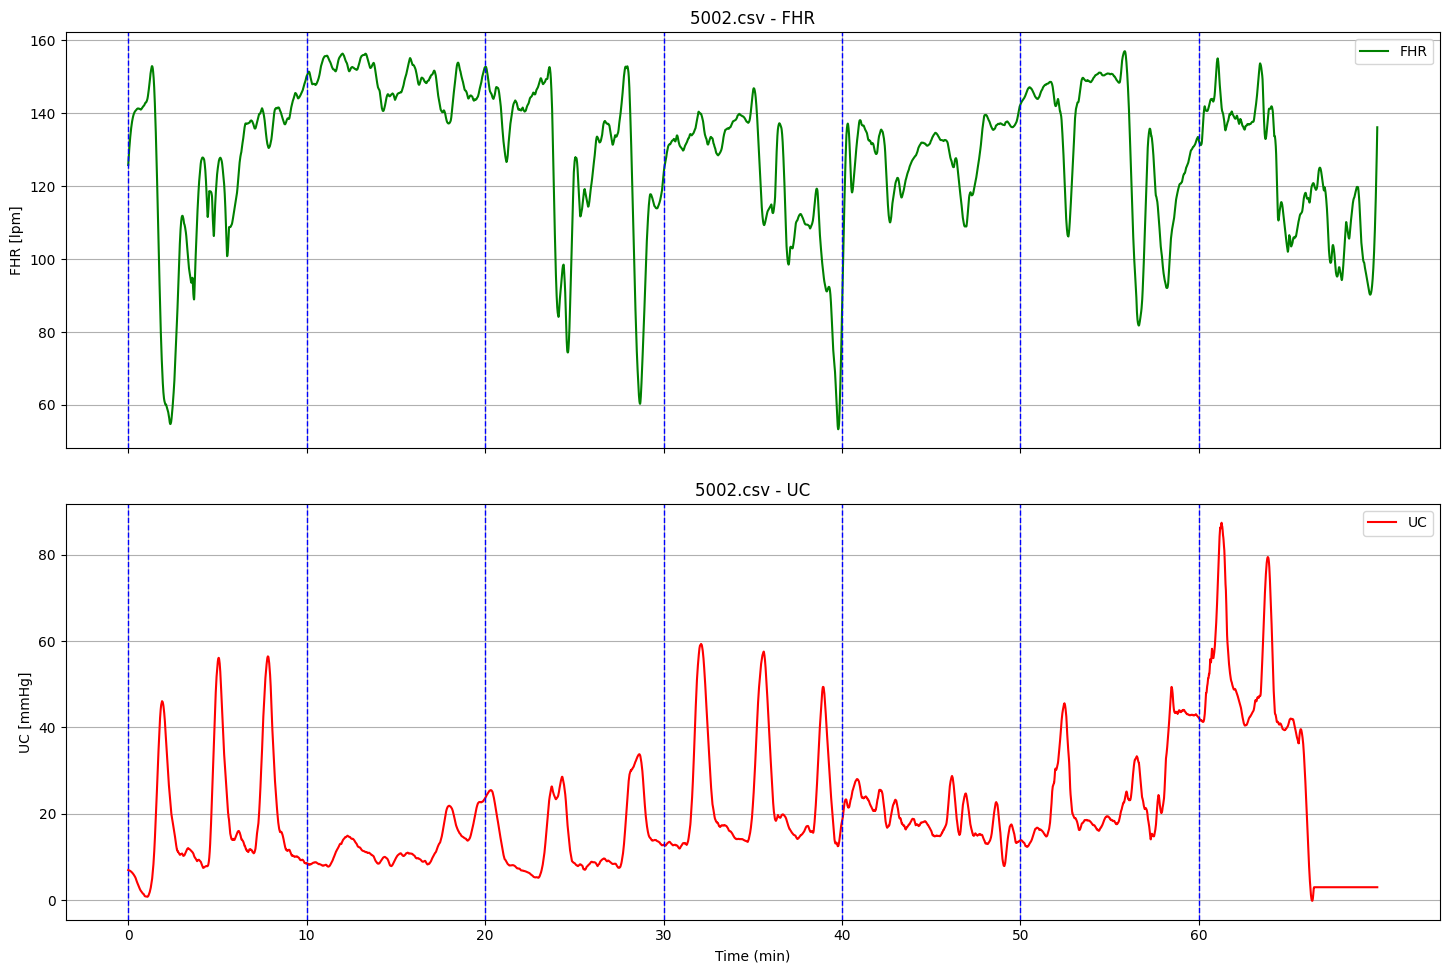

In [6]:
file = "5002.csv"
seconds = train_dataset.loc[file]["seconds"]
FHR = train_dataset.loc[file]["FHR"]
UC = train_dataset.loc[file]["UC"]

# Convertir segundos a minutos
minutes = seconds / 60

# Crear la figura
plt.figure(figsize=(15, 5))

fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
fig.tight_layout(pad=3.0)

# Graficar FHR en el primer subplot
axs[0].plot(minutes, FHR, label="FHR", color="g")
for minute in range(0, int(max(minutes)), 10):
    axs[0].axvline(x=minute, color="b", linestyle="--", linewidth=1)
axs[0].set_title(f"{file} - FHR")
axs[0].set_ylabel("FHR [lpm]")
axs[0].set_xticks(range(0, int(max(minutes)), 10))
axs[0].legend()
axs[0].grid()

# Graficar UC en el segundo subplot
axs[1].plot(minutes, UC, label="UC", color="r")
for minute in range(0, int(max(minutes)), 10):
    axs[1].axvline(x=minute, color="b", linestyle="--", linewidth=1)
axs[1].set_title(f"{file} - UC")
axs[1].set_xlabel("Time (min)")
axs[1].set_ylabel("UC [mmHg]")
axs[1].set_xticks(range(0, int(max(minutes)), 10))
axs[1].legend()
axs[1].grid()

# Mostrar la figura
plt.show()

In [17]:
df_train_OG = pd.read_csv("./data/train.csv")
df_test_OG = pd.read_csv("./data/test.csv")
train_features_dataset = df_train_OG.copy()
test_features_dataset = df_test_OG.copy()

In [23]:
train_features_dataset.head()

,recordID,babyhealth,gestweeks,sex,age,gravidity,parity,diabetes,hypertension,preeclampsia,pyrexia,meconium,noprogress,rectype
0,5086,1,38.0,1.0,27.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,5491,0,40.0,1.0,32.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,12.0
2,5097,0,41.0,1.0,29.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,5108,1,39.0,1.0,29.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5264,0,39.0,1.0,28.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [24]:
train_features_dataset.describe()

,recordID,babyhealth,gestweeks,sex,age,gravidity,parity,diabetes,hypertension,preeclampsia,pyrexia,meconium,noprogress,rectype
count,386.000000,386.000000,386.000000,386.000000,386.000000,384.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,384.000000
mean,5275.430052,0.194301,39.927461,1.448187,29.707254,1.455729,0.417098,0.072539,0.080311,0.025907,0.012953,0.121762,0.103627,1.940104
std,160.428554,0.396175,1.182084,0.497954,4.608834,1.028634,0.785993,0.259715,0.272127,0.159063,0.113220,0.327435,0.305172,2.794821
min,5002.000000,0.000000,37.000000,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,5139.250000,0.000000,39.000000,1.000000,27.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,5272.500000,0.000000,40.000000,1.000000,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5414.750000,0.000000,41.000000,2.000000,33.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,5552.000000,1.000000,43.000000,2.000000,42.000000,8.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000


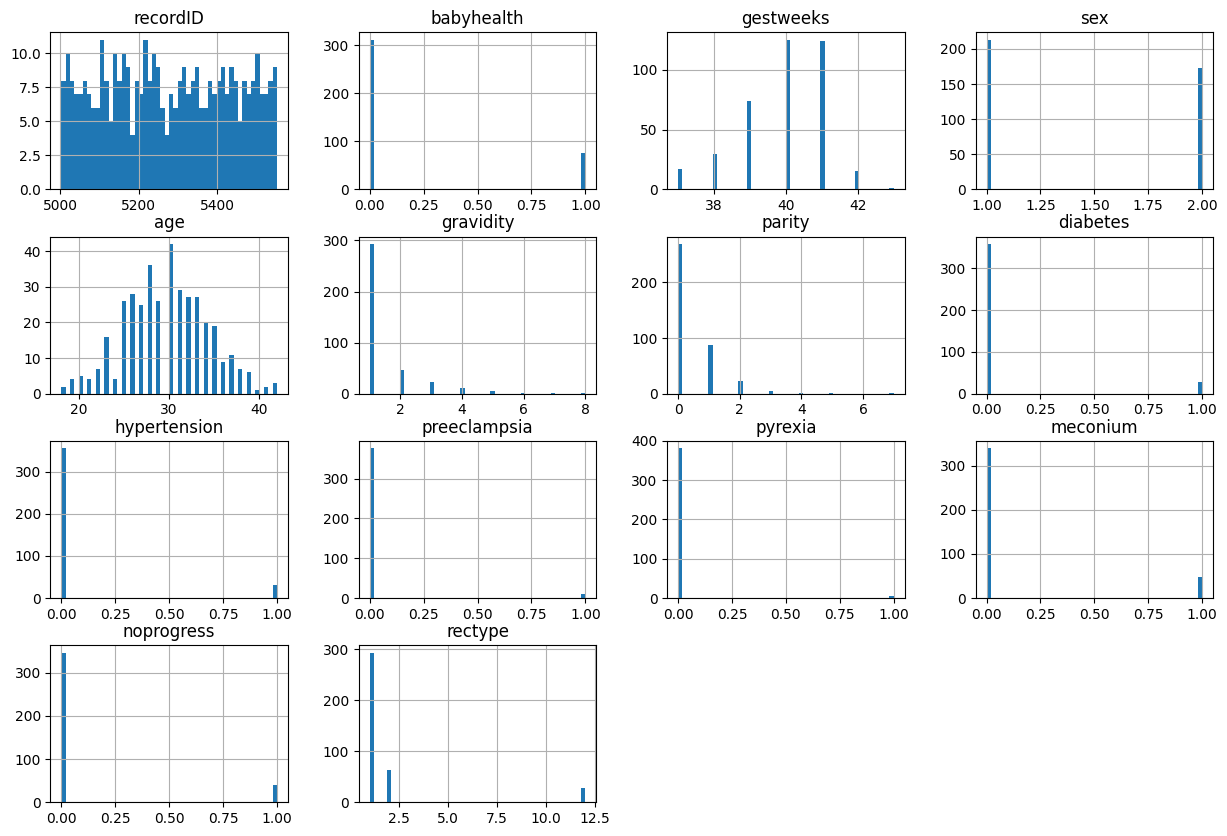

In [29]:
train_features_dataset.hist(figsize=(15, 10), bins=50)
plt.show()

In [39]:
corr_matrix = train_features_dataset.corr()
corr_matrix["babyhealth"].sort_values(ascending=False)

babyhealth      1.000000
noprogress      0.090833
hypertension    0.023531
gestweeks       0.013535
age            -0.007175
recordID       -0.008511
sex            -0.021250
diabetes       -0.036362
rectype        -0.038850
preeclampsia   -0.038868
meconium       -0.042691
pyrexia        -0.056257
gravidity      -0.090670
parity         -0.144158
Name: babyhealth, dtype: float64

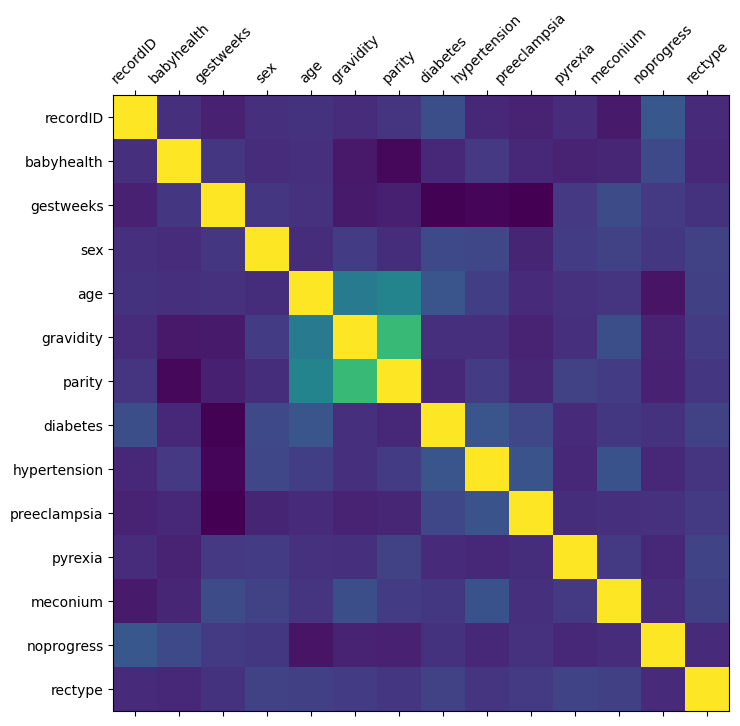

In [50]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(corr_matrix)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.show()